<a href="https://colab.research.google.com/github/JoeL-8883/Fencing-Score-Predictor/blob/main/predict_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from bs4 import BeautifulSoup
import requests

In [37]:
df = pd.read_csv('/content/data.csv')
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
df.head()

,current_rank,fencer_name,fencer_nationality,event_name,event_type,points,date
5044,327,JORGENSEN Philippe,DEN,Londres,Satellite,0.0,2007-10-21
5019,315,KAO Alex,USA,Londres,Satellite,0.0,2007-10-21
5026,316,ALEXANDER David,IRL,Londres,Satellite,0.0,2007-10-21
5034,321,EL-SALEH Michael,USA,Londres,Satellite,0.0,2007-10-21
5036,323,ANDERSON Robert,USA,Londres,Satellite,0.0,2007-10-21


In [38]:
'''Remove satellite events - these give very few points so even winning a satellite implies that a fencer performed poorly'''
'''We can assume that top fencers do not attend these events - they are the subject of this project for now'''
'''At some point I will have to devise a better metric than points'''
df = df[df['event_type'] != 'Satellite']

'''Delete data for fencers who have been to less than n competitions'''

# NOTE - the threshold must be equal to sequence_length / train_split
threshold = 20 # the number of non-satellite events each fencer must have attended to be considered
fencer_counts = df['fencer_name'].value_counts()
fencers_to_delete = fencer_counts[fencer_counts < 20].index
print(f'Deleting {len(fencers_to_delete)} fencers')
df = df[~df['fencer_name'].isin(fencers_to_delete)]

Deleting 1741 fencers


Different levels of competitions multiply points by different factors, for instance, in the Olympics you can see the spike in points in Cheung Ka Long's two Olympic golds. So we use and predict rolling averages

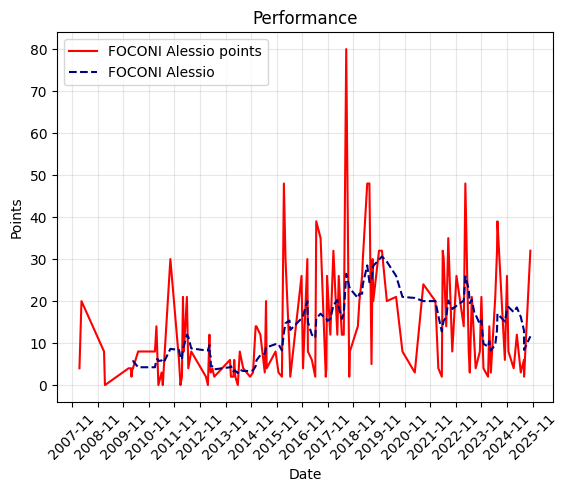

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fencer_name = 'FOCONI Alessio'
df_fencer = df[df['fencer_name'] == fencer_name]
plt.title('Performance')
plt.xlabel('Date')
plt.ylabel('Points')

# Compute rolling averages
window = 8
rolling_avg = df_fencer['points'].rolling(window=window).mean()
plt.plot(df_fencer['date'], df_fencer['points'], label=fencer_name + ' points', color='red')
plt.plot(df_fencer['date'], rolling_avg, label=fencer_name, color='navy', linestyle='--')


plt.grid(True, alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()


In [40]:
window_size = 8
# Compute rolling averages
df['rolling_avg_points'] = df.groupby('fencer_name')['points'].transform(lambda x: x.rolling(window=window_size).mean())

# Fill NaN values
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(0) # Fill any remaining NaNs with 0 if necessary


<ipython-input-40-cfe51ed51744>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value


In [41]:
points_mean = df['points'].mean()
points_std = df['points'].std()
df['points_normalised'] = (df['points'] - points_mean) / points_std

rolling_mean = df['rolling_avg_points'].mean()
rolling_std = df['rolling_avg_points'].std()
df['rolling_avg_points_normalised'] = (df['rolling_avg_points'] - rolling_mean) / rolling_std

### Predictive Model

Dataset

Points alone is not good enough data in predicting a fencer's performance in the future, we need to include features such as their rank at the time, their age, etc.

In [42]:
'''One-hot encoding of fencer's nationality'''
one_hot_nationality = pd.get_dummies(df['fencer_nationality'], prefix='nationality')
df = pd.concat([df, one_hot_nationality], axis=1)
df.head()

,current_rank,fencer_name,fencer_nationality,event_name,event_type,points,date,rolling_avg_points,points_normalised,rolling_avg_points_normalised,...,nationality_SVK,nationality_SWE,nationality_THA,nationality_TPE,nationality_TUN,nationality_TUR,nationality_UKR,nationality_USA,nationality_VEN,nationality__AIN
4056,36,ASPROMONTE Valerio,ITA,Bonn,World Cup,0.0,2008-01-03,9.0,-0.578391,0.55545,...,False,False,False,False,False,False,False,False,False,False
4016,32,ALI Xavier Lahoussine,FRA,Bonn,World Cup,2.0,2008-01-03,9.0,-0.356763,0.55545,...,False,False,False,False,False,False,False,False,False,False
4733,186,WESSELS Andre,GER,Bonn,World Cup,4.0,2008-01-03,9.0,-0.135135,0.55545,...,False,False,False,False,False,False,False,False,False,False
4046,35,GRIDNEV Igor,RUS,Bonn,World Cup,2.0,2008-01-03,9.0,-0.356763,0.55545,...,False,False,False,False,False,False,False,False,False,False
4064,37,PANCHAN Nontapat,THA,Bonn,World Cup,0.0,2008-01-03,9.0,-0.578391,0.55545,...,False,False,True,False,False,False,False,False,False,False


~~Number of competitions -- we would expect that fencers peak after a number of competitions, however their performance will also degrade as they get older and their physique wears down.~~

We can't use this as this counts instances of competitions, not the nth competition a fencer actually competed in!

In [43]:
#df['competition_count'] = df.groupby('fencer_name').cumcount() + 1

In [44]:
class FencerSequenceDataset(Dataset):
  def __init__(self, df, sequence_length=11):
    self.sequences = []
    self.targets = []
    self.sequence_length = sequence_length

    for fencer_name, fencer_df in df.items():
      ranking_data = fencer_df[['points_normalised', 'rolling_avg_points_normalised', 'current_rank']].values
      nationality_columns = [col for col in fencer_df.columns if col.startswith('nationality_')]
      features = np.concatenate((ranking_data, fencer_df[nationality_columns].values), axis=1)

      # Create sliding windows
      for i in range(len(features) - sequence_length):
        point = features[i:i+sequence_length]
        target = features[i+sequence_length, 1] # only predict rolling_avg_points_normalised

        self.sequences.append(torch.tensor(point, dtype=torch.float32)) # convert to tensors so they can be stacked
        self.targets.append(torch.tensor(target, dtype=torch.float32))

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    return self.sequences[idx], self.targets[idx]


In [45]:
''' Split the data for each fencer'''
data_size = len(df)
train_split = 0.6
val_split = 0.2
test_split = 0.2

fencer_train_data = {}
fencer_val_data = {}
fencer_test_data = {}

fencers_grouped = df.groupby('fencer_name') # We can naively assume that each fencer has a different name

for fencer_name, fencer_df in fencers_grouped:
  fencer_df = fencer_df.sort_values(by='date')

  total_size = len(fencer_df)
  train_size = int(total_size * train_split)
  val_size = int(total_size * val_split)
  test_size = total_size - train_size - val_size

  # Split Data
  fencer_train_data[fencer_name] = fencer_df[:train_size]
  fencer_val_data[fencer_name] = fencer_df[train_size:train_size + val_size]
  fencer_test_data[fencer_name] = fencer_df[train_size + val_size:]

In [46]:
training_data = FencerSequenceDataset(fencer_train_data)
val_data = FencerSequenceDataset(fencer_val_data)
test_data = FencerSequenceDataset(fencer_test_data)

batch_size=32
train_dataloader = DataLoader(training_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Setup model

In [47]:
'''Start with a basic RNN'''
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.25):
      super(RNN, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.dropout = nn.Dropout(dropout)

      self.W_ih = nn.Linear(input_size, hidden_size, bias=True) # input to hidden
      self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True) # hidden weights
      self.W_ho = nn.Linear(hidden_size, output_size, bias=True) # hidden to output

    def forward(self, input, h_0=None):
      if h_0 is None:
        h_0 = torch.zeros(self.hidden_size, device=device)

      input = self.dropout(input)
      h_t = torch.tanh(self.W_ih(input) + self.W_hh(h_0))
      h_t = self.dropout(h_t)
      ouput = self.W_ho(h_t)

      return ouput, h_t



In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [49]:
'''Valdiation'''
def evaluate_model(model, dataloader):
  model.eval()
  total_val_loss = 0
  num_batches = 0

  with torch.no_grad():
    for sequences, targets in val_dataloader:
      sequences = sequences.to(device)
      targets = targets.to(device)
      batch_loss = 0
      for sequence, target in zip(sequences, targets):
        hidden_state = None
        output = None

        for t in range(len(sequence)):
          output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

        # Calculate loss for each prediction in the sequence
        loss = criterion(output, target.unsqueeze(0))
        batch_loss += loss.item()

      batch_loss /= len(sequences) # Average the batch loss
      num_batches += 1
      total_val_loss += batch_loss * len(sequences)

  average_val_loss = total_val_loss / (num_batches * batch_size)
  print(f'Average Validation Loss: {average_val_loss:.4f}')
  return average_val_loss

In [50]:
input_size = 3 # number of features
nationality_count = len([col for col in df.columns if col.startswith('nationality_')])
input_size += nationality_count

hidden_size = 250 # A larger hidden_size causes the model to overfit
output_size = 1 # i.e. predicting points earned from a competition

l2_strength = 0.0075
dropout = 0.4
best_val_loss = float('inf')
patience = 5
counter = 0
best_model = None


model = RNN(input_size, hidden_size, output_size, dropout)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20 # model seems to converge after 10 epochs

for epoch in range(epochs):
  total_train_loss = 0
  num_batches = 0

  model.train()

  for sequences, targets in train_dataloader: # iterate through each batch
    sequences = sequences.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    for sequence, target in zip(sequences, targets): # iterate through each sequence in the batch (zip pairs sequences and targets)
      hidden_state = torch.zeros(model.hidden_size, device=device) # reset the hidden state for each sequence
      output = None
      batch_loss = 0

      for t in range(len(sequence)):
        output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

        loss = criterion(output, target.unsqueeze(0)) # loss for a single sequence
        batch_loss += loss # losses for all sequences in a batch

      # L2 regularisation loss
      l2_reg = torch.tensor(0.).to(sequences.device)
      for param in model.parameters():
        l2_reg += torch.norm(param, 2)
      batch_loss += l2_strength * l2_reg

      batch_loss /= len(sequences)

    # Make gradient updates on each batch
    batch_loss.backward()
    optimizer.step()

    total_train_loss += batch_loss.item() * len(sequences)
    num_batches += 1

  average_train_loss = total_train_loss / (num_batches * batch_size)
  print(f'Epoch [{epoch+1}/{epochs}], Average Training Loss: {average_train_loss:.4f}')

  # Validation loss
  val_loss = evaluate_model(model, val_dataloader)

  if val_loss < best_val_loss:
    counter = 0
    best_val_loss = val_loss
    best_model = model.state_dict()
  else:
    counter += 1

    if counter >= patience:
      print(f'Early stopping at epoch {epoch+1}')
      break
    best_val_loss = min(best_val_loss, val_loss)

  torch.save(best_model, 'model.pth')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Average Training Loss: 0.4592
Average Validation Loss: 0.3015
Epoch [2/20], Average Training Loss: 0.2881
Average Validation Loss: 0.4455
Epoch [3/20], Average Training Loss: 0.2538
Average Validation Loss: 0.6597
Epoch [4/20], Average Training Loss: 0.2315
Average Validation Loss: 0.5890
Epoch [5/20], Average Training Loss: 0.2461
Average Validation Loss: 0.5644
Epoch [6/20], Average Training Loss: 0.2408
Average Validation Loss: 0.5129
Early stopping at epoch 6


In [51]:
model_save_path = '/content/model.pth'
torch.save(model.state_dict(), model_save_path)
print("Model saved to " + model_save_path)

Model saved to /content/model.pth


In [52]:
'''Testing'''
model.eval()
total_test_loss = 0
num_batches = 0

with torch.no_grad():
  for sequences, targets in test_dataloader:
    sequences = sequences.to(device)
    targets = targets.to(device)
    batch_loss = 0
    for sequence, target in zip(sequences, targets):
      hidden_state = None
      output = None

      for t in range(len(sequence)):
        output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

      loss = criterion(output, target.unsqueeze(0))
      batch_loss += loss.item()

    batch_loss /= len(sequences)
    num_batches += 1
    total_test_loss += batch_loss * len(sequences)

average_test_loss = total_test_loss / (num_batches * batch_size)
print(f'Average Test Loss: {average_test_loss:.4f}')

Average Test Loss: 0.4662


In [53]:
model_save_path = '/content/model.pth'
model = RNN(input_size, hidden_size, output_size)
model = model.to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

def fencer_forecast(model, initial_sequence_df, num_predictions, sequence_length):
  predicted_rolling_avg_list = []
  current_sequence_df = initial_sequence_df.copy()
  nationality_cols = [col for col in initial_sequence_df.columns if col.startswith('nationality_')]
  last_nationality_features = current_sequence_df[nationality_cols].iloc[-1].values.tolist() #iloc gets the last row
  current_rank = current_sequence_df['current_rank'].iloc[-1]
  #competition_count = current_sequence_df['competition_count'].iloc[-1]

  counter = 0 # number of times a prediction is made

  # Get data for a prediction
  for i in range(num_predictions):
    ranking_data = current_sequence_df[['points_normalised', 'rolling_avg_points_normalised', 'current_rank']].values
    features = np.concatenate((ranking_data, current_sequence_df[nationality_cols]), axis=1)
    features_tensor = torch.tensor(features, dtype=torch.float32, device=device)

    # Make predictions
    with torch.no_grad():
      hidden_state = None
      output = None
      for t in range(sequence_length):
        output, hidden_state = model(features_tensor[t+counter].unsqueeze(0), hidden_state)
      counter += 1

      predicted_rolling_avg_normalised = output.item()
      predicted_rolling_avg = predicted_rolling_avg_normalised * rolling_std + rolling_mean
      predicted_rolling_avg_list.append(predicted_rolling_avg)

    '''Make a dataframe for the next prediction'''
    next_prediction_df = pd.DataFrame({
        'points': predicted_rolling_avg,
        'rolling_avg_points': predicted_rolling_avg,
        'points_normalised': predicted_rolling_avg_normalised,
        'rolling_avg_points_normalised': predicted_rolling_avg_normalised,
        'current_rank': current_rank,
        #'competition_count': competition_count + 1
    }, index=[0])

    # Add nationalities
    for col, val in zip(nationality_cols, last_nationality_features):
      next_prediction_df[col] = val

    # Create dataframe row for predicted event
    predicted_event_df = pd.DataFrame(next_prediction_df)
    current_sequence_df = pd.concat([current_sequence_df, predicted_event_df], ignore_index=True)

  return predicted_rolling_avg_list




In [54]:
fencer_name = 'FOCONI Alessio'
num_predictions = 10
sequence_length = 11

fencer_df_pred = df[df['fencer_name'] == fencer_name]
fencer_df_pred = fencer_df_pred.sort_values(by='date')

initial_sequence_df = fencer_df_pred.tail(sequence_length)

predictions = fencer_forecast(model, initial_sequence_df, num_predictions, sequence_length)
print(predictions)

[np.float64(19.406480948222782), np.float64(21.07502578164476), np.float64(21.93034386679708), np.float64(22.588704951603916), np.float64(22.925185549595284), np.float64(23.13585481651816), np.float64(23.258873396971552), np.float64(23.330579005799734), np.float64(23.37267312153874), np.float64(23.397113162991374)]


TODO:
* Visualise model's predictive capacity for held out data
* Write code to determine the next date of a competition for making interpretable predictions
* Add another column representing the nth competiton entered, this could be used as a proxy for age

In [55]:
def get_next_comp_date(fencer_df):
  # Get the last row in the dataframe
  last_row = fencer_df.iloc[-1]
  # Retrieve the date
  last_date = last_row['date']
  print(last_date)

fencer_df = df[df['fencer_name'] == 'COOK Jaimie']
fencer_df = fencer_df.sort_values(by='date')
get_next_comp_date(fencer_df)



2025-10-01 00:00:00


ISSUES:
* We need a way to also predict the fencers rank in the future, as the fencers same rank cannot be used for predictions as well as training


